1.	User_ID						User ID
2.	Product_ID					Product ID
3.	Gender						Sex of User
4.	Age							Age in bins
5.	Occupation					Occupation (Masked)
6.	City_Category				Category of the City (A,B,C)
7.	Stay_In_Current_City_Years	Number of years stay in current city
8.	Marital_Status				Marital Status
9.	Product_Category_1			Product Category (Masked)
10.	Product_Category_2			Product may belongs to other category also (Masked)
11.	Product_Category_3			Product may belongs to other category also (Masked)
12.	Purchase					Purchase Amount (Target Variable)

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [80]:
df_raw = pd.read_csv('data/train.csv')

EDA
1. variable identification
2. univariate analysis
3. bivariate analysis
4. missing value treatment
5. outlier treatment
6. variable transformation
7. variable creation

In [64]:
#variable identification
df_preproc = pd.DataFrame((df_raw).copy())
df_preproc.drop('User_ID',axis=1,inplace=True)

In [65]:
# excepct User_ID, target variable Purchase , all predictors are categorical
cols = df_preproc.columns[:-1] 
for col in cols:
    df_preproc[col] = df_preproc[col].astype('object')
df_preproc['Purchase'] = df_preproc['Purchase'].astype('int32')
# we don't need userID beecuase User details are already there

In [66]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   Product_ID                  550068 non-null  object
 1   Gender                      550068 non-null  object
 2   Age                         550068 non-null  object
 3   Occupation                  550068 non-null  object
 4   City_Category               550068 non-null  object
 5   Stay_In_Current_City_Years  550068 non-null  object
 6   Marital_Status              550068 non-null  object
 7   Product_Category_1          550068 non-null  object
 8   Product_Category_2          376430 non-null  object
 9   Product_Category_3          166821 non-null  object
 10  Purchase                    550068 non-null  int32 
dtypes: int32(1), object(10)
memory usage: 44.1+ MB


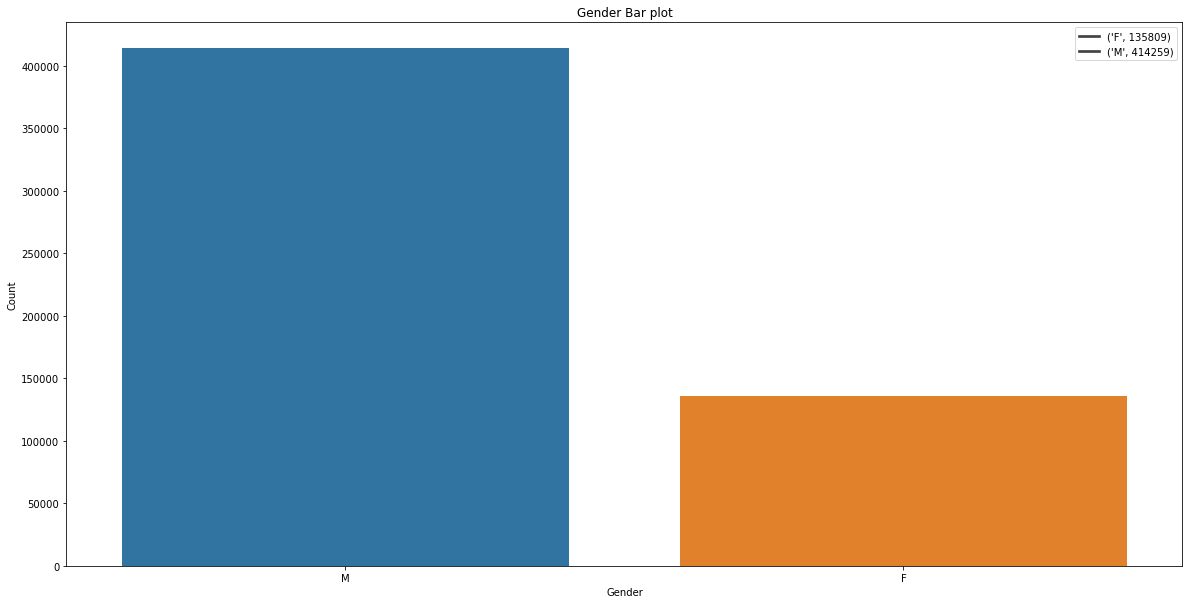

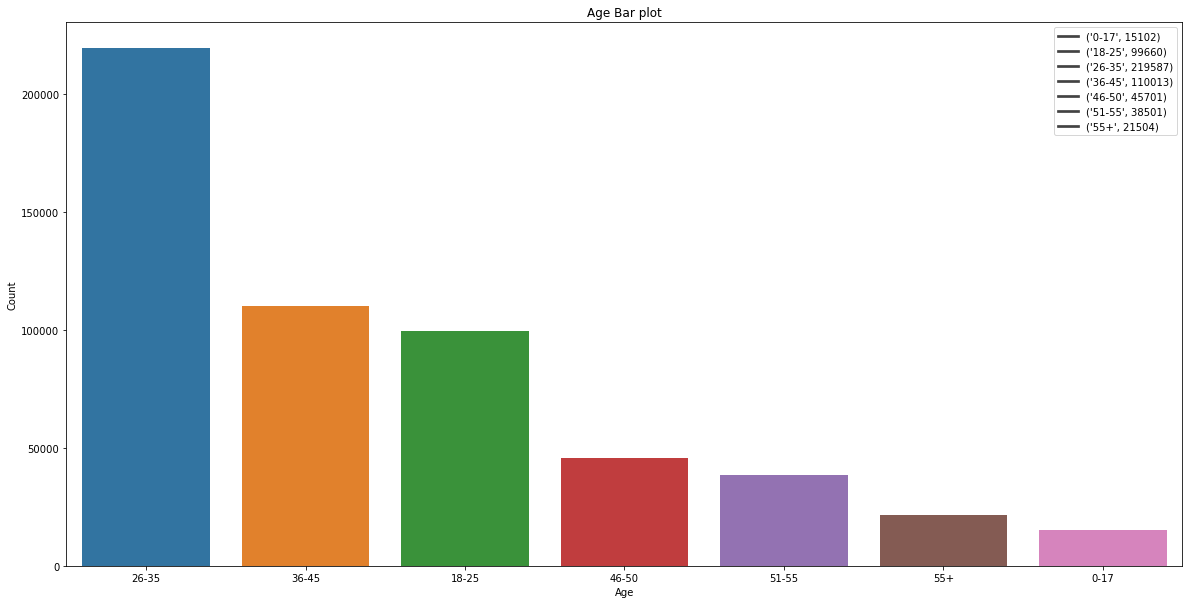

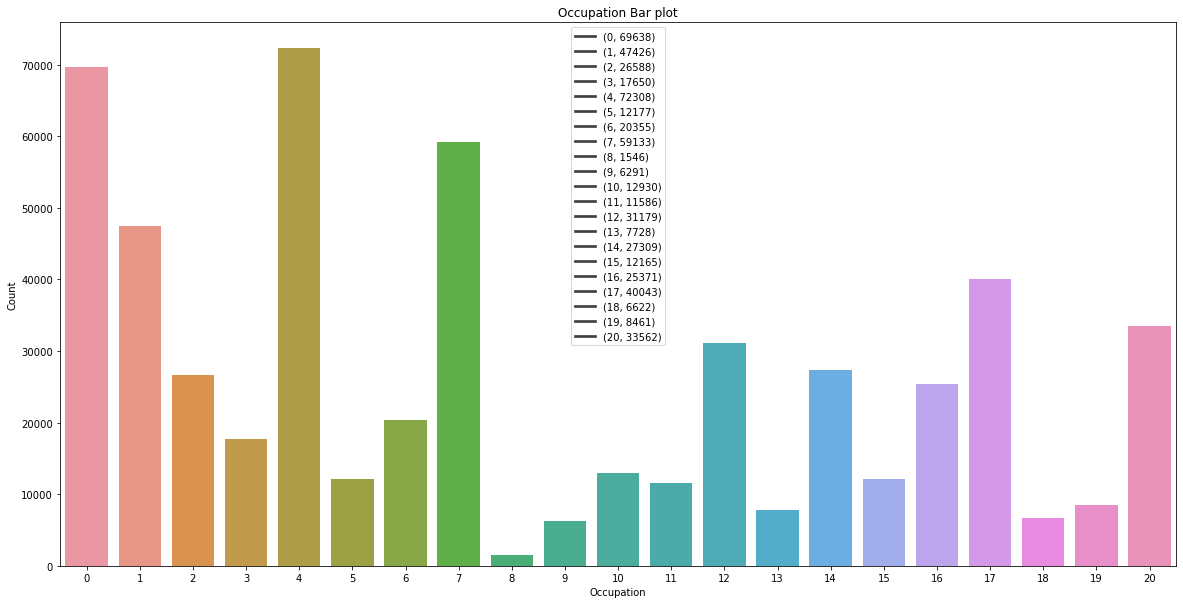

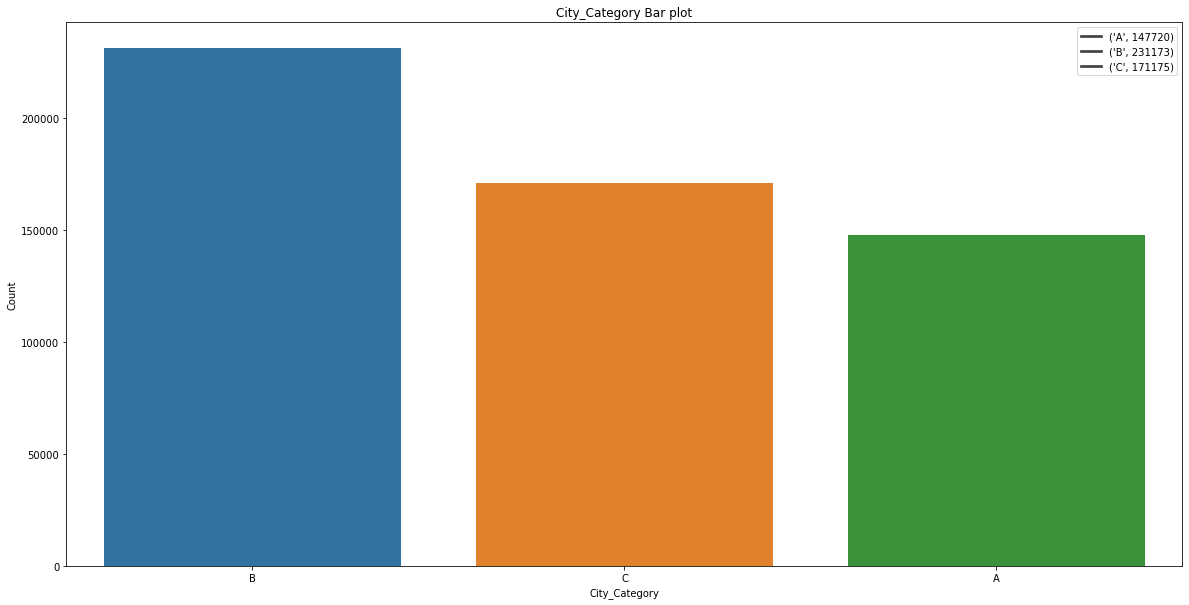

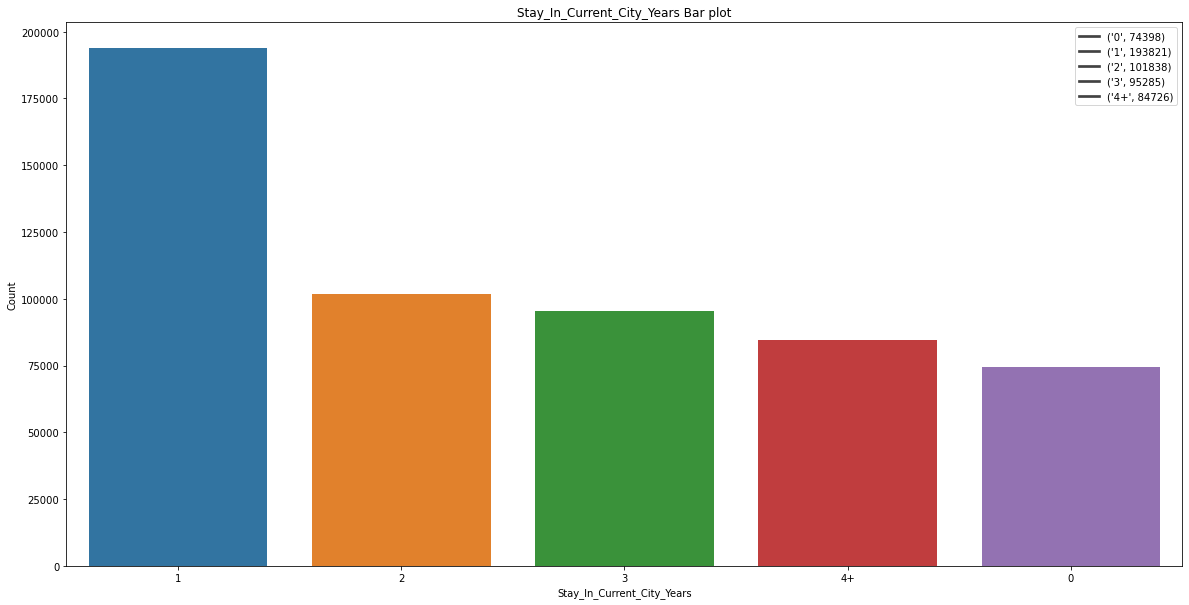

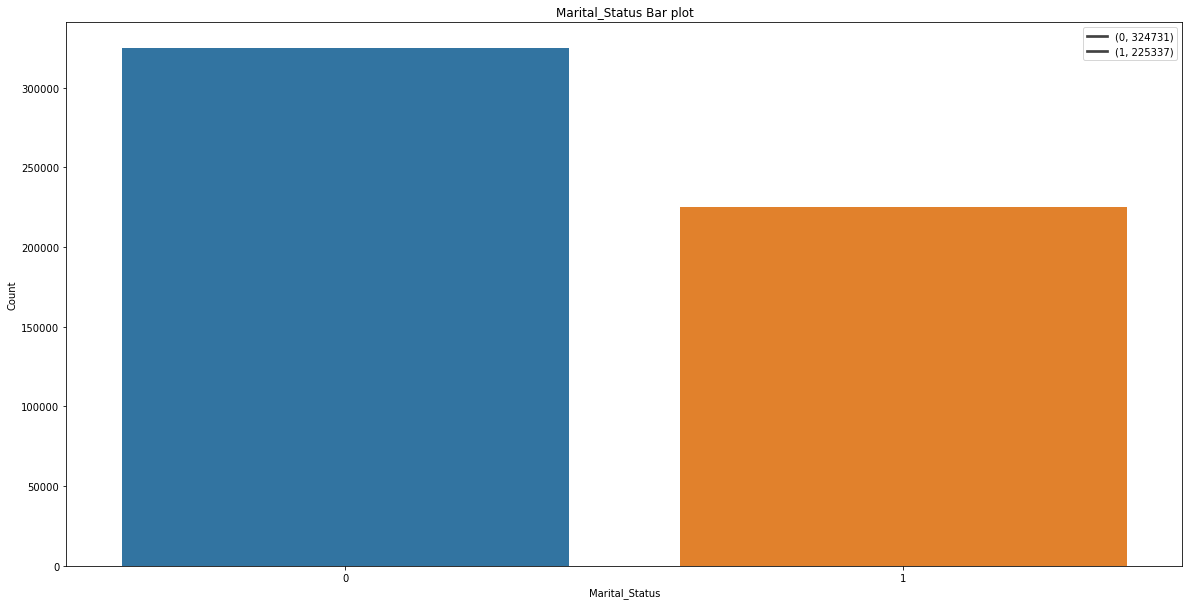

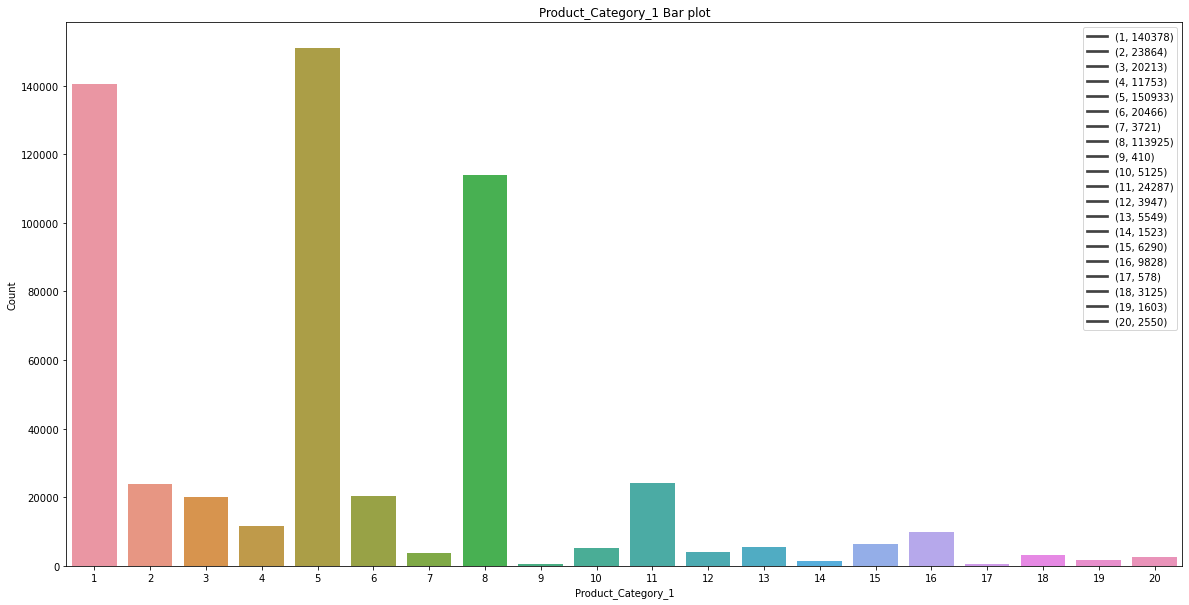

In [18]:
#univariate analysis
#numeric cols : hist, box plot
#categoric cols : bar chart
cat_cols = df_preproc.columns[1:-3]
figrows = len(cat_cols)
figcols = 1
figindex = 1

for col in cat_cols:
    plt.figure(figsize=(20,10))
    #plt.subplot(figrows,figcols,figindex)
    data = df_preproc[col].value_counts()
    sns.barplot(data.index,data)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title('{} Bar plot'.format(col))
    plt.legend([(k,v) for (k,v) in sorted(df_preproc[col].value_counts().items())])
    figindex += 1
    plt.show()

In [19]:
# central tendency and dispersion can be know by describing the dataframe
print(df_preproc.info())
print(df_preproc.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   Product_ID                  550068 non-null  object
 1   Gender                      550068 non-null  object
 2   Age                         550068 non-null  object
 3   Occupation                  550068 non-null  object
 4   City_Category               550068 non-null  object
 5   Stay_In_Current_City_Years  550068 non-null  object
 6   Marital_Status              550068 non-null  object
 7   Product_Category_1          550068 non-null  object
 8   Product_Category_2          376430 non-null  object
 9   Product_Category_3          166821 non-null  object
 10  Purchase                    550068 non-null  int32 
dtypes: int32(1), object(10)
memory usage: 44.1+ MB
None
            Purchase
count  550068.000000
mean     9263.968713
std      5023.065394
min    

In [20]:
df_preproc.isna().sum()

Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

we have missing values for both Product_Category_2 and Product_Category_3. so we can not take it


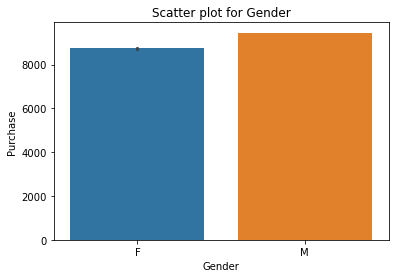

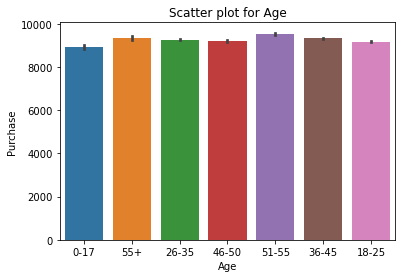

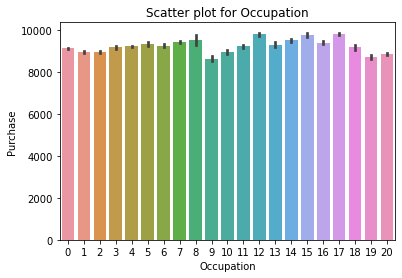

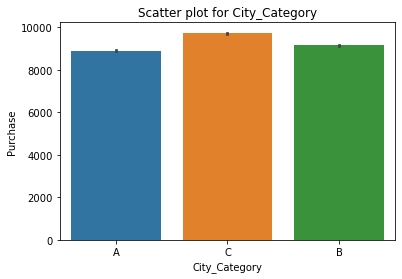

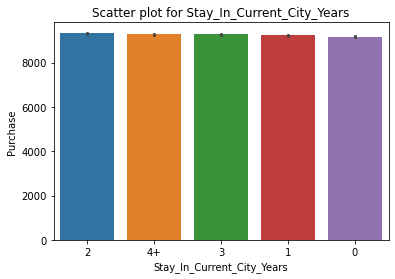

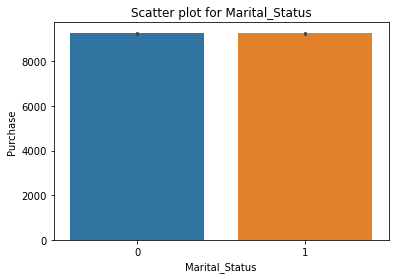

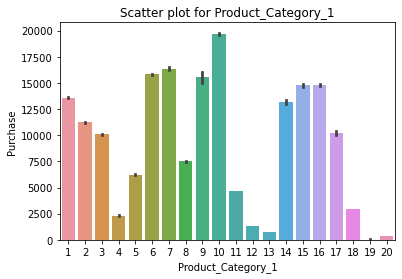

In [21]:
#bivariate analysis.
# continuous vs continuous : correlations and scatered plots. we don't need it as we don't have any coninuous feature
# categorical vs categorical : chi-square test
# categorical vs categorical : Z-test,t-test and ANOVA .
# so we need to do  Z-test,t-test and ANOVA. but we have many missing values in Product_Category_2, Product_Category_3
# so we can test with remaining

cat_cols = df_preproc.columns[1:-3]
target_col = 'Purchase'
print('we have missing values for both Product_Category_2 and Product_Category_3. so we can not take it')
for col in cat_cols:
    sns.barplot(x=df_preproc[col], y=df_preproc[target_col])
    plt.xlabel(col)
    plt.ylabel(target_col)
    plt.title('Scatter plot for {}'.format(col))
    plt.show()

In [6]:
#missing value treatment
[(x,(df_preproc[x].isna().sum()/df_preproc[col].sum()) * 100) for x in df_preproc.columns]
#we can see Product_Category_2 (5%) and Product_Category_3(12%)

[('User_ID', 0.0),
 ('Product_ID', 0.0),
 ('Gender', 0.0),
 ('Age', 0.0),
 ('Occupation', 0.0),
 ('City_Category', 0.0),
 ('Stay_In_Current_City_Years', 0.0),
 ('Marital_Status', 0.0),
 ('Product_Category_1', 0.0),
 ('Product_Category_2', 8.216325995621126),
 ('Product_Category_3', 18.1347532731534),
 ('Purchase', 0.0)]

In [39]:
#its not good to remove that missing data, we need to impute. But before that we need to analyse the data related to product
# product_ID, Product_Category_1 Product_Category_2 Product_Category_3. How product id is forming?
#p00 and 42 is common for all product ids. 
df_preproc['Product_Category_2'].max()

18.0

In [67]:
df_preproc.isna().sum()

Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

In [68]:
df_drop = df_preproc.copy()#df_preproc.dropna().copy()
df_drop.isna().sum()

Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

In [58]:
def getCountVar(compute_df, count_df, var_name):
    grouped_df = count_df.groupby(var_name)
    count_dict = {}
    for name, group in grouped_df:
        count_dict[name] = group.shape[0]
    count_list = []
    for index, row in compute_df.iterrows():
        name = row[var_name]
        count_list.append(count_dict.get(name, 0))
    return count_list

In [104]:
cat_cols = df_drop.columns[:-1]
lstvalucounts = [{col:df_drop[col].value_counts().to_dict()} for col in cat_cols]
lstvalucounts = dict(lstvalucounts)
lstvalucounts

ValueError: dictionary update sequence element #0 has length 1; 2 is required

In [119]:
frq_cols = ['Product_ID','Age','Occupation','Stay_In_Current_City_Years','Product_Category_1','Product_Category_2','Product_Category_3']
for valcount in lstvalucounts:
    print(valcount.items())

dict_items([('Product_ID', {'P00265242': 1880, 'P00025442': 1615, 'P00110742': 1612, 'P00112142': 1562, 'P00057642': 1470, 'P00184942': 1440, 'P00046742': 1438, 'P00058042': 1422, 'P00059442': 1406, 'P00145042': 1406, 'P00237542': 1394, 'P00255842': 1383, 'P00117942': 1364, 'P00110942': 1360, 'P00010742': 1350, 'P00220442': 1282, 'P00110842': 1281, 'P00117442': 1260, 'P00051442': 1249, 'P00102642': 1246, 'P00278642': 1226, 'P00242742': 1215, 'P00034742': 1212, 'P00148642': 1204, 'P00080342': 1203, 'P00031042': 1200, 'P00028842': 1197, 'P00251242': 1187, 'P00114942': 1178, 'P00270942': 1152, 'P00000142': 1152, 'P00112542': 1131, 'P00044442': 1111, 'P00334242': 1093, 'P00111142': 1015, 'P00277642': 989, 'P00052842': 982, 'P00116842': 979, 'P00295942': 972, 'P00005042': 969, 'P00003442': 968, 'P00086442': 966, 'P00258742': 964, 'P00085942': 963, 'P00110542': 958, 'P00216342': 943, 'P00128942': 936, 'P00073842': 936, 'P00113242': 933, 'P00112442': 923, 'P00105142': 917, 'P0097242': 912, 'P

In [77]:
cat_cols = ['Gender','Age','City_Category']
df_encoded = df_drop[['Product_ID']].copy()
for col in cat_cols:
    temp=pd.get_dummies(df_drop[col],prefix='{}__'.format(col))
    df_encoded=pd.concat([df_encoded,temp],axis=1)
df_encoded['Purchase'] = df_drop['Purchase']
df_preprocessed = df_encoded.copy()

In [78]:
df_preprocessed.info()
#preprocessed data is ready. now we can start modelling

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   Product_ID                  550068 non-null  object
 1   Gender                      550068 non-null  object
 2   Age                         550068 non-null  object
 3   Occupation                  550068 non-null  object
 4   City_Category               550068 non-null  object
 5   Stay_In_Current_City_Years  550068 non-null  object
 6   Marital_Status              550068 non-null  object
 7   Product_Category_1          550068 non-null  object
 8   Product_Category_2          376430 non-null  object
 9   Product_Category_3          166821 non-null  object
 10  Purchase                    550068 non-null  int32 
 11  Age___0-17                  550068 non-null  uint8 
 12  Age___18-25                 550068 non-null  uint8 
 13  Age___26-35                 5

In [37]:
X,y = df_preprocessed.iloc[:,:-1].values, df_preprocessed.iloc[:,-1].values

In [38]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [39]:
xgb_reg = xgb.XGBRegressor(random_state=10,n_jobs=2,eval_metric='error')
pipe = Pipeline([('xgb_model',xgb_reg)])
params_grid = {'xgb_model__n_estimators':[5,6,7],'xgb_model__subsample':np.arange(0.5,1,0.5),'xgb_model__max_depth':np.arange(400,700,100)}

In [40]:
cv_range=np.arange(4,5)
with (tqdm(len(cv_range))) as bar:
    for cv in cv_range:
        r_searchcv = RandomizedSearchCV(estimator=pipe,param_distributions=params_grid,cv=cv,scoring='neg_root_mean_squared_error')
        r_searchcv.fit(X_train,y_train)
        print('best_score : {}, best_params : {}'.format(np.abs(r_searchcv.score(X_test,y_test)),[(k,v) for (k,v) in r_searchcv.best_params_.items()]))
        bar.update()


0it [00:12, ?it/s]


ValueError: could not convert string to float: 'P00121242'

In [25]:
xgb.XGBRegressor?

In [20]:
np.arange(50,80,10)

array([50, 60, 70])